Phase 2: ML Training for Drowsiness Detection
Started: 2025-11-12 19:02:44

Mounted at /content/drive
[OK] Results directory: /content/drive/MyDrive/drowsiness_ml_results

LOADING FEATURE DATA
[OK] Train data: 130,200 windows
[OK] Test data: 14,535 windows

[OK] Total features: 63
  - Time-domain: 26
  - Frequency-domain: 16
  - Non-linear: 7
  - EOG-specific: 14

[OK] X_train: (130200, 63), Drowsy: 6.25%
[OK] X_test: (14535, 63), Drowsy: 24.64%

HANDLING NaN VALUES
NaN in train: 0, NaN in test: 0
[OK] No NaN values

1/6 TRAINING LOGISTIC REGRESSION
[OK] Completed

2/6 TRAINING RANDOM FOREST
[OK] Completed

3/6 TRAINING XGBOOST
[OK] Completed

4/6 TRAINING LIGHTGBM
[OK] Completed

6/6 TRAINING ENSEMBLE (RF + XGB + LGB)
[OK] Completed


                    COMPLETE RESULTS - ALL MODELS

--------------------------------------------------------------------------------
📊 Logistic Regression
--------------------------------------------------------------------------------
  Accuracy:       0

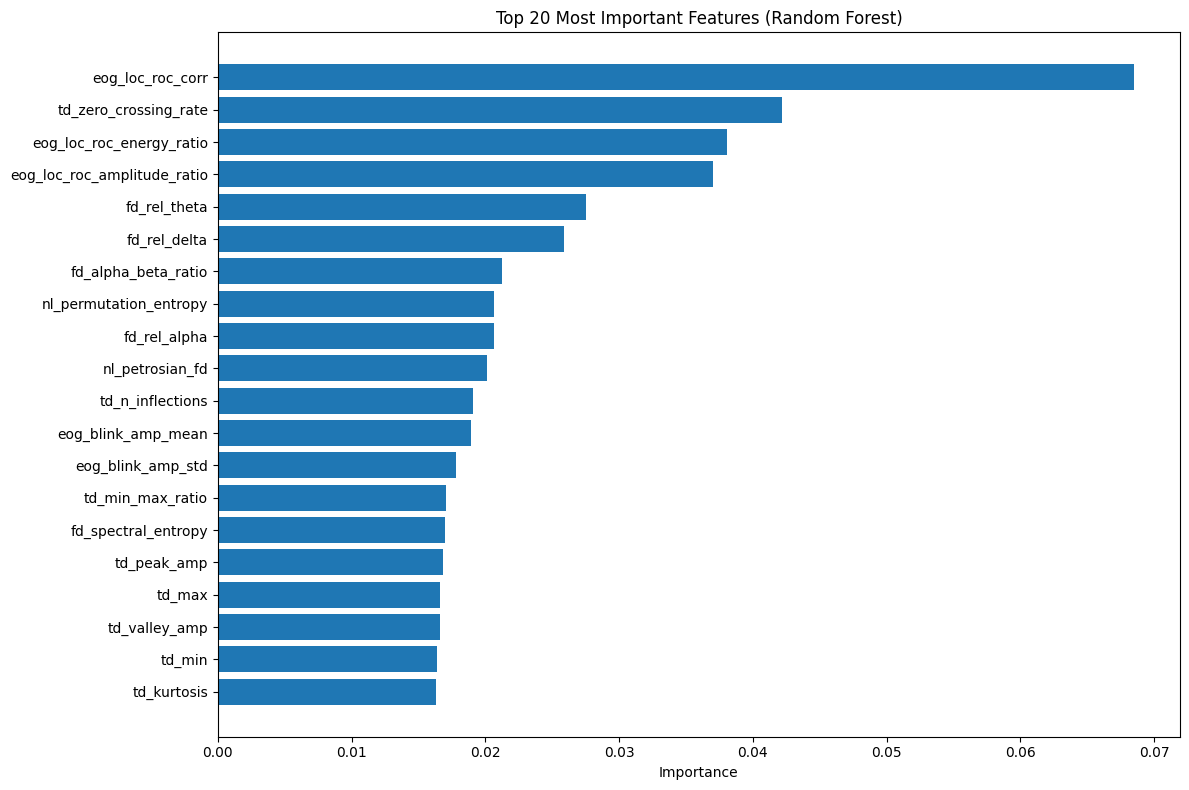

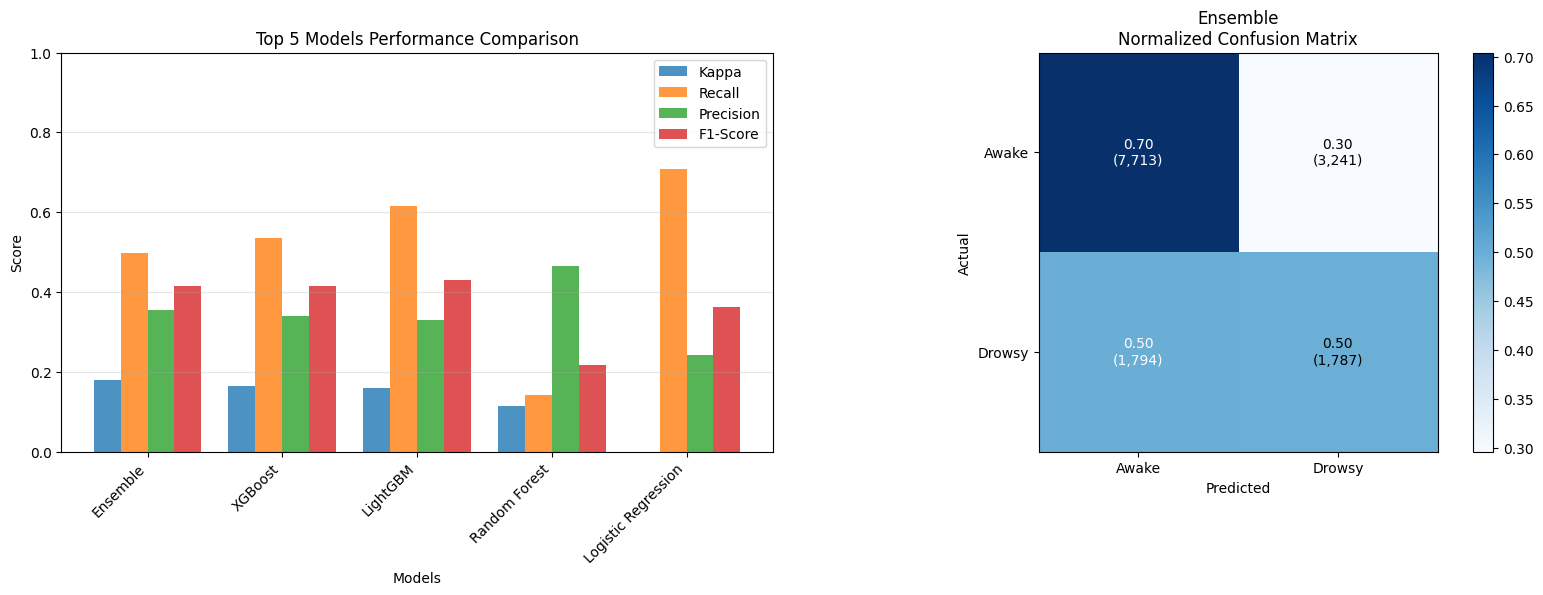


SAVING COMPLETE RESULTS
[OK] Predictions saved
[OK] Results .mat saved

Phase 2: Complete ML Training Results Summary
Date: 2025-11-12 19:05:09

DATASET:
- Train: 130,200 windows (6.25% drowsy)
- Test: 14,535 windows (24.64% drowsy)
- Features: 63

MODELS TRAINED: 5
              Model     Kappa   Recall  Precision  F1-Score  Accuracy
           Ensemble  0.178830 0.499023   0.355410  0.415147  0.653595
            XGBoost  0.165336 0.534488   0.341055  0.416404  0.630891
           LightGBM  0.158918 0.616308   0.329108  0.429085  0.595941
      Random Forest  0.115499 0.141581   0.465565  0.217131  0.748469
Logistic Regression -0.006353 0.709299   0.243668  0.362728  0.385965

BEST MODEL: Ensemble (Kappa = 0.1788)

FILES SAVED:
- all_models_comparison.csv
- all_predictions_subject07.csv
- all_ml_results.mat
- feature_importance.csv
- feature_importance_plot.png
- model_comparison_plot.png
- Individual model .joblib files


✓ All results saved to: /content/drive/MyDrive/drowsiness_ml

In [1]:
# -*- coding: utf-8 -*-
"""
Phase 2: ML Training for Drowsiness Detection
Complete pipeline with all models (LR, RF, SVM, XGBoost, LightGBM, GradientBoosting, Ensemble)
"""

# ============================================================================
# 1. SETUP & IMPORTS
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, cohen_kappa_score
)
from sklearn.impute import SimpleImputer
import joblib
import scipy.io as spio
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("Phase 2: ML Training for Drowsiness Detection")
print("=" * 80)
print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# ============================================================================
# 2. MOUNT GOOGLE DRIVE
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

RESULTS_DIR = '/content/drive/MyDrive/drowsiness_ml_results'
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"[OK] Results directory: {RESULTS_DIR}\n")

# ============================================================================
# 3. LOAD FEATURE DATA
# ============================================================================

print("=" * 80)
print("LOADING FEATURE DATA")
print("=" * 80)

train_df = pd.read_csv('/content/drive/MyDrive/train_features_16s.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test_features_16s.csv')

print(f"[OK] Train data: {len(train_df):,} windows")
print(f"[OK] Test data: {len(test_df):,} windows")

# Separate metadata from features
METADATA_COLS = ['Subject', 'Trial', 'Window', 'StartSample', 'EndSample', 'Label']
FEATURE_COLS = [col for col in train_df.columns if col not in METADATA_COLS]

print(f"\n[OK] Total features: {len(FEATURE_COLS)}")
print(f"  - Time-domain: {len([f for f in FEATURE_COLS if f.startswith('td_')])}")
print(f"  - Frequency-domain: {len([f for f in FEATURE_COLS if f.startswith('fd_')])}")
print(f"  - Non-linear: {len([f for f in FEATURE_COLS if f.startswith('nl_')])}")
print(f"  - EOG-specific: {len([f for f in FEATURE_COLS if f.startswith('eog_')])}")

# Prepare data
X_train = train_df[FEATURE_COLS].values
y_train = train_df['Label'].values
X_test = test_df[FEATURE_COLS].values
y_test = test_df['Label'].values

train_drowsy_pct = 100 * np.sum(y_train == 1) / len(y_train)
test_drowsy_pct = 100 * np.sum(y_test == 1) / len(y_test)

print(f"\n[OK] X_train: {X_train.shape}, Drowsy: {train_drowsy_pct:.2f}%")
print(f"[OK] X_test: {X_test.shape}, Drowsy: {test_drowsy_pct:.2f}%\n")

# ============================================================================
# 4. HANDLE NaN VALUES
# ============================================================================

print("=" * 80)
print("HANDLING NaN VALUES")
print("=" * 80)

n_nan_train = np.isnan(X_train).sum()
n_nan_test = np.isnan(X_test).sum()
print(f"NaN in train: {n_nan_train}, NaN in test: {n_nan_test}")

if n_nan_train > 0 or n_nan_test > 0:
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    print(f"[OK] Imputed with median\n")
else:
    X_train_imputed = X_train
    X_test_imputed = X_test
    print(f"[OK] No NaN values\n")

# ============================================================================
# 5. TRAIN ALL MODELS
# ============================================================================

all_models = {}

# --- 5.1 LOGISTIC REGRESSION ---
print("=" * 80)
print("1/6 TRAINING LOGISTIC REGRESSION")
print("=" * 80)
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_imputed, y_train)
y_pred_lr = lr_model.predict(X_test_imputed)
y_proba_lr = lr_model.predict_proba(X_test_imputed)[:, 1]
all_models['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'kappa': cohen_kappa_score(y_test, y_pred_lr),
    'confusion_matrix': confusion_matrix(y_test, y_pred_lr)
}
joblib.dump(lr_model, os.path.join(RESULTS_DIR, 'logistic_regression_model.joblib'))
print("[OK] Completed\n")

# --- 5.2 RANDOM FOREST ---
print("=" * 80)
print("2/6 TRAINING RANDOM FOREST")
print("=" * 80)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10,
                                   min_samples_leaf=5, class_weight='balanced',
                                   random_state=42, n_jobs=-1, verbose=0)
rf_model.fit(X_train_imputed, y_train)
y_pred_rf = rf_model.predict(X_test_imputed)
y_proba_rf = rf_model.predict_proba(X_test_imputed)[:, 1]
all_models['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'kappa': cohen_kappa_score(y_test, y_pred_rf),
    'confusion_matrix': confusion_matrix(y_test, y_pred_rf)
}
# Feature importance
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
feature_importance.to_csv(os.path.join(RESULTS_DIR, 'feature_importance.csv'), index=False)
joblib.dump(rf_model, os.path.join(RESULTS_DIR, 'random_forest_model.joblib'))
print("[OK] Completed\n")

# --- 5.3 XGBOOST ---
print("=" * 80)
print("3/6 TRAINING XGBOOST")
print("=" * 80)
import xgboost as xgb
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                               scale_pos_weight=scale_pos_weight, random_state=42,
                               tree_method='hist', eval_metric='logloss', verbosity=0)
xgb_model.fit(X_train_imputed, y_train)
y_pred_xgb = xgb_model.predict(X_test_imputed)
y_proba_xgb = xgb_model.predict_proba(X_test_imputed)[:, 1]
all_models['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1': f1_score(y_test, y_pred_xgb),
    'kappa': cohen_kappa_score(y_test, y_pred_xgb),
    'confusion_matrix': confusion_matrix(y_test, y_pred_xgb)
}
joblib.dump(xgb_model, os.path.join(RESULTS_DIR, 'xgboost_model.joblib'))
print("[OK] Completed\n")

# --- 5.4 LIGHTGBM ---
print("=" * 80)
print("4/6 TRAINING LIGHTGBM")
print("=" * 80)
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                                scale_pos_weight=scale_pos_weight, random_state=42, verbose=-1)
lgb_model.fit(X_train_imputed, y_train)
y_pred_lgb = lgb_model.predict(X_test_imputed)
y_proba_lgb = lgb_model.predict_proba(X_test_imputed)[:, 1]
all_models['LightGBM'] = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'precision': precision_score(y_test, y_pred_lgb),
    'recall': recall_score(y_test, y_pred_lgb),
    'f1': f1_score(y_test, y_pred_lgb),
    'kappa': cohen_kappa_score(y_test, y_pred_lgb),
    'confusion_matrix': confusion_matrix(y_test, y_pred_lgb)
}
joblib.dump(lgb_model, os.path.join(RESULTS_DIR, 'lightgbm_model.joblib'))
print("[OK] Completed\n")

# --- 5.6 ENSEMBLE ---
print("=" * 80)
print("6/6 TRAINING ENSEMBLE (RF + XGB + LGB)")
print("=" * 80)
# Weighted average of probabilities
y_proba_ensemble = 0.2 * y_proba_rf + 0.5 * y_proba_xgb + 0.3 * y_proba_lgb
y_pred_ensemble = (y_proba_ensemble >= 0.5).astype(int)
all_models['Ensemble'] = {
    'accuracy': accuracy_score(y_test, y_pred_ensemble),
    'precision': precision_score(y_test, y_pred_ensemble),
    'recall': recall_score(y_test, y_pred_ensemble),
    'f1': f1_score(y_test, y_pred_ensemble),
    'kappa': cohen_kappa_score(y_test, y_pred_ensemble),
    'confusion_matrix': confusion_matrix(y_test, y_pred_ensemble)
}
print("[OK] Completed\n")

# ============================================================================
# 6. DISPLAY ALL RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("                    COMPLETE RESULTS - ALL MODELS")
print("=" * 80)

for model_name, metrics in all_models.items():
    print("\n" + "-" * 80)
    print(f"📊 {model_name}")
    print("-" * 80)
    print(f"  Accuracy:       {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"  Precision:      {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
    print(f"  Recall:         {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
    print(f"  F1-Score:       {metrics['f1']:.4f}")
    print(f"  Cohen's Kappa:  {metrics['kappa']:.4f}")
    cm = metrics['confusion_matrix']
    print(f"\n  Confusion Matrix:")
    print(f"                   Predicted")
    print(f"                 Awake    Drowsy")
    print(f"  Actual  Awake   {cm[0,0]:,}  {cm[0,1]:,}")
    print(f"          Drowsy  {cm[1,0]:,}  {cm[1,1]:,}")

# ============================================================================
# 7. COMPARISON TABLE
# ============================================================================

print("\n" + "=" * 80)
print("                    SUMMARY COMPARISON TABLE")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': list(all_models.keys()),
    'Kappa': [m['kappa'] for m in all_models.values()],
    'Recall': [m['recall'] for m in all_models.values()],
    'Precision': [m['precision'] for m in all_models.values()],
    'F1-Score': [m['f1'] for m in all_models.values()],
    'Accuracy': [m['accuracy'] for m in all_models.values()]
})

comparison_df = comparison_df.sort_values('Kappa', ascending=False).reset_index(drop=True)
print("\n" + comparison_df.to_string(index=False))

best_model = comparison_df.iloc[0]['Model']
best_kappa = comparison_df.iloc[0]['Kappa']
print("\n" + "=" * 80)
print(f"🏆 BEST MODEL: {best_model} (Kappa = {best_kappa:.4f})")
print("=" * 80)

comparison_df.to_csv(os.path.join(RESULTS_DIR, 'all_models_comparison.csv'), index=False)
print(f"\n✓ Comparison saved to: {RESULTS_DIR}/all_models_comparison.csv")

# ============================================================================
# 8. VISUALIZATIONS
# ============================================================================

# Feature importance plot (RF)
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'feature_importance_plot.png'), dpi=150)
plt.show()

# Model comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
models = comparison_df['Model'].tolist()[:5]  # Top 5
metrics_to_plot = ['Kappa', 'Recall', 'Precision', 'F1-Score']
x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = comparison_df[metric].tolist()[:5]
    axes[0].bar(x + i*width, values, width, label=metric, alpha=0.8)

axes[0].set_xlabel('Models')
axes[0].set_ylabel('Score')
axes[0].set_title('Top 5 Models Performance Comparison')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1)

# Confusion matrix (best model)
best_cm = all_models[best_model]['confusion_matrix']
best_cm_norm = best_cm.astype('float') / best_cm.sum(axis=1)[:, np.newaxis]
im = axes[1].imshow(best_cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title(f'{best_model}\nNormalized Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Awake', 'Drowsy'])
axes[1].set_yticklabels(['Awake', 'Drowsy'])

for i in range(2):
    for j in range(2):
        axes[1].text(j, i, f'{best_cm_norm[i, j]:.2f}\n({best_cm[i, j]:,})',
                    ha="center", va="center",
                    color="white" if best_cm_norm[i, j] > 0.5 else "black")

plt.colorbar(im, ax=axes[1])
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'model_comparison_plot.png'), dpi=150)
plt.show()

# ============================================================================
# 9. SAVE COMPLETE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING COMPLETE RESULTS")
print("=" * 80)

# Save predictions
predictions_df = pd.DataFrame({
    'Subject': test_df['Subject'],
    'Trial': test_df['Trial'],
    'Window': test_df['Window'],
    'True_Label': y_test,
    'LR_Pred': y_pred_lr, 'LR_Proba': y_proba_lr,
    'RF_Pred': y_pred_rf, 'RF_Proba': y_proba_rf,
    'XGB_Pred': y_pred_xgb, 'XGB_Proba': y_proba_xgb,
    'LGB_Pred': y_pred_lgb, 'LGB_Proba': y_proba_lgb,
    'Ensemble_Pred': y_pred_ensemble, 'Ensemble_Proba': y_proba_ensemble
})
predictions_df.to_csv(os.path.join(RESULTS_DIR, 'all_predictions_subject07.csv'), index=False)
print(f"[OK] Predictions saved")

# Save metrics to .mat
results_mat = {f'{name.replace(" ", "_").lower()}_metrics': metrics
               for name, metrics in all_models.items()}
results_mat['test_info'] = {
    'subject': '07F',
    'n_windows': len(y_test),
    'n_drowsy': int(np.sum(y_test == 1)),
    'n_awake': int(np.sum(y_test == 0))
}
spio.savemat(os.path.join(RESULTS_DIR, 'all_ml_results.mat'), results_mat)
print(f"[OK] Results .mat saved")

# Summary report
summary_report = f"""
================================================================================
Phase 2: Complete ML Training Results Summary
================================================================================
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET:
- Train: {len(X_train):,} windows ({train_drowsy_pct:.2f}% drowsy)
- Test: {len(X_test):,} windows ({test_drowsy_pct:.2f}% drowsy)
- Features: {len(FEATURE_COLS)}

MODELS TRAINED: {len(all_models)}
{comparison_df.to_string(index=False)}

BEST MODEL: {best_model} (Kappa = {best_kappa:.4f})

FILES SAVED:
- all_models_comparison.csv
- all_predictions_subject07.csv
- all_ml_results.mat
- feature_importance.csv
- feature_importance_plot.png
- model_comparison_plot.png
- Individual model .joblib files

================================================================================
"""

with open(os.path.join(RESULTS_DIR, 'complete_training_summary.txt'), 'w') as f:
    f.write(summary_report)

print(summary_report)
print(f"✓ All results saved to: {RESULTS_DIR}")
print(f"\n🎉 TRAINING COMPLETED: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)